Before running the code the upload the zipped files cat_and_dog.zip and face_img.zip in google drive if colab is the selected platform. Assign the variables as follows:  
zipped_cat_dog_dir ='Address of the cat and dog image file(zipped)'  
zipped_human_dir='Address of the human images zipped file'  
Then execute the script sequencely for getting the proper outputs.  
script startING with ! should be run in terminal.
The code first re arrange input file structure to the below form 
----data  
-------cat_dog  
----------test  
----------train  
-------human  
----------test  
----------train    
The output folders are      
-----saved_models(where the models are saved agfter each epochs)  
-----generated_images(images created during training)  
-----test_results(contains generated test data)  

In [1]:
zipped_cat_dog_dir='/content/gdrive/MyDrive/data/cat/cat_and_dog.zip' # pass the arguments here.
zipped_human_dir='/content/gdrive/MyDrive/data/man/face_img.zip'
output_folder='/content/gdrive/MyDrive/'

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!rm -r /data/* #to delete the contents in data file if it exists.

In [5]:
import zipfile
import os
zip_ref = zipfile.ZipFile(zipped_cat_dog_dir, 'r') #Opens the zip file in read
zip_ref.extractall('/data') #Extracts the files into the /data folder
zip_ref.close()
import zipfile
import os
zip_ref = zipfile.ZipFile(zipped_human_dir, 'r') #Opens the zip file in read
zip_ref.extractall('/data') #Extracts the files into the /data folder
zip_ref.close()
zip_ref=zipfile.ZipFile('/data/cat_face.zip','r')
zip_ref.extractall('/data')
zip_ref.close()
zip_ref=zipfile.ZipFile('/data/UTK Face Cropped.zip','r')
zip_ref.extractall('/data')
zip_ref.close()
zip_ref=zipfile.ZipFile('/data/dog faces.zip','r')
zip_ref.extractall('/data')
zip_ref.close()

In [6]:
import os
a=os.path.join(output_folder,'saved_models')
b=os.path.join(output_folder,'generated_images')
c=os.path.join(output_folder,'test_results')

In [ ]:
#run only if the directories are not created
os.mkdir(a)
os.mkdir(b)
os.mkdir(c)

In [7]:
!mkdir /data/cat_dog
!mkdir /data/human
!mkdir /data/cat_dog/train
!mkdir /data/human/train
!mkdir /data/human/test
!mkdir /data/cat_dog/test
!mkdir /data/cat_dog/test/classes
!mkdir /data/human/test/classes
!mkdir /data/cat_dog/train/classes
!mkdir /data/human/train/classes
!cp /data/Cat-faces-dataset-master/dataset-part1/dataset-part1/*.png /data/cat_dog/train/classes
!cp /data/Cat-faces-dataset-master/dataset-part2/dataset-part2/*.png /data/cat_dog/train/classes
!cp /data/Cat-faces-dataset-master/dataset-part3/dataset-part3/*.png /data/cat_dog/train/classes
!cp -r /data/utkcropped/*.jpg /data/human/train/classes
!cp /content/gdrive/MyDrive/cycleGan_test_human/* /data/human/test/classes #test data is passed here , the folder is /content/gdrive/MyDrive/cycleGan_test_human

In [8]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 38.5 MB/s eta 0:00:00


In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_addons as tfa
import tensorflow_datasets as tfds

tfds.disable_progress_bar()
autotune = tf.data.AUTOTUNE

In [10]:
bht=!ls /data/human/train/classes | wc -l
bht=int(bht[0])
bct=!ls /data/cat_dog/train/classes | wc -l
bct=int(bct[0])
bhte=!ls /data/human/test/classes | wc -l
bhte=int(bhte[0])
bcte=!ls /data/cat_dog/test/classes | wc -l
bcte=int(bcte[0])

In [11]:
import os
import os
import shutil

dest_dir = "/data/cat_dog/train/classes"
extension='.jpg'
index=1

def list_files(path):
    files = []
    index=1
    for root, dirs, filenames in os.walk(path):
        for file in filenames:
            file_path = os.path.join(root, file)
            # Rename the file with an incrementing variable
            new_name = f"file{index}{extension}"
            os.rename(file_path, os.path.join(root, new_name))
    
    # Copy the renamed file to the destination directory
            shutil.copy(os.path.join(root, new_name), dest_dir)
            index+=1
    return None

path = '/data/train/'
list_files(path)


In [12]:
!rm /data/*.zip
!rm -r /data/Cat-faces-dataset-master
!rm -r /data/utkcropped
!rm -r /data/test_200_database
!rm -r /data/test_200_single_img
!rm -r /data/train

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.nasnet import preprocess_input#tf.keras..preprocess_input
data_datagen = ImageDataGenerator()
data_generator_human= data_datagen.flow_from_directory('/data/human/train/',target_size=(64, 64),batch_size=bht,classes=None,class_mode=None,shuffle=0)
data_generator_cat_dog= data_datagen.flow_from_directory('/data/cat_dog/train/',target_size=(64, 64),batch_size=bct,classes=None,class_mode=None,shuffle=0)
data_generator_cat_dog_test= data_datagen.flow_from_directory('/data/cat_dog/test/',target_size=(64, 64),batch_size=bcte,classes=None,class_mode=None,shuffle=0)
data_generator_human_test= data_datagen.flow_from_directory('/data/human/test',target_size=(64, 64),batch_size=bhte,classes=None,class_mode=None,shuffle=0)

Found 23709 images belonging to 1 classes.
Found 48090 images belonging to 1 classes.
Found 0 images belonging to 1 classes.
Found 5 images belonging to 1 classes.


In [14]:
train_h=data_generator_human.next()
train_c_d=data_generator_cat_dog.next()
test_h=data_generator_human_test.next()
test_c_d=data_generator_cat_dog_test.next()

In [15]:
import tensorflow as tf

# convert to TensorFlow dataset
dataset_human= tf.data.Dataset.from_tensor_slices(train_h)
dataset_cat_dog = tf.data.Dataset.from_tensor_slices(train_c_d)
dataset_human_test= tf.data.Dataset.from_tensor_slices(test_h)
dataset_cat_test = tf.data.Dataset.from_tensor_slices(test_c_d)
# add prefetching
train_h_1 = dataset_human.prefetch(tf.data.AUTOTUNE)
train_c_d_1 = dataset_cat_dog.prefetch(tf.data.AUTOTUNE)
test_h_1 = dataset_human_test.prefetch(tf.data.AUTOTUNE)
test_c_d_1 = dataset_cat_test.prefetch(tf.data.AUTOTUNE)

In [16]:
import gc # clearing Ram 
del train_h,train_c_d,test_h,test_c_d
gc.collect()

0

In [17]:
orig_img_size = (64, 64)
# Size of the random crops to be used during training.
input_img_size = (64, 64, 3)
# Weights initializer for the layers.
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

buffer_size = 256
batch_size = 1


def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    # Map values in the range [-1, 1]
    return (img / 127.5) - 1.0


def preprocess_train_image(img):
    # Random flip
    img = tf.image.random_flip_left_right(img)
    # Resize to the original size first
    img = tf.image.resize(img, [*orig_img_size])
    # Random crop to 256X256
    img = tf.image.random_crop(img, size=[*input_img_size])
    # Normalize the pixel values in the range [-1, 1]
    img = normalize_img(img)
    return img


def preprocess_test_image(img):
    # Only resizing and normalization for the test images.
    img = tf.image.resize(img, [input_img_size[0], input_img_size[1]])
    img = normalize_img(img)
    return img

In [18]:
# Apply the preprocessing operations to the training data
train_human = (
    train_h_1.map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)
train_cat_dog = (
    train_c_d_1.map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)



In [19]:
# Apply the preprocessing operations to the test data
test_human = (
    test_h_1.map(preprocess_test_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)
test_cat_dog = (
    test_c_d_1.map(preprocess_test_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)

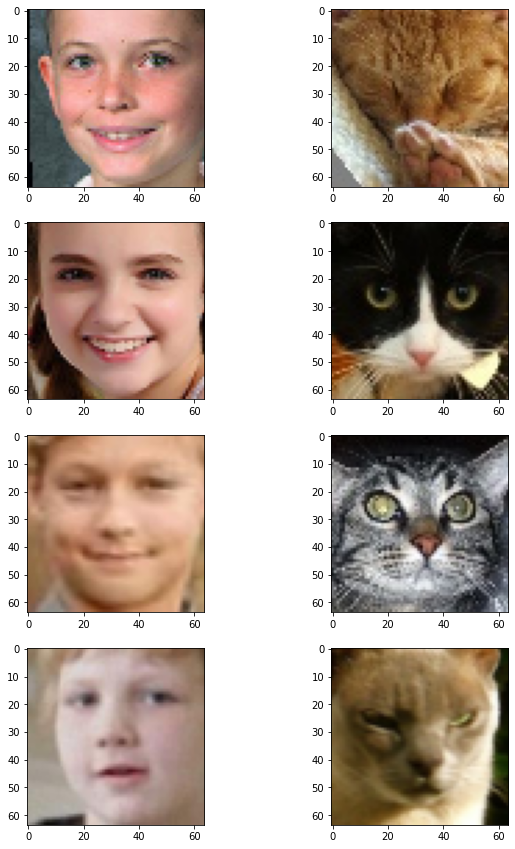

In [20]:
import matplotlib.pyplot as plt
_, ax = plt.subplots(4, 2, figsize=(10, 15))
for i, samples in enumerate(zip(train_human.take(4), train_cat_dog.take(4))):
    horse = (((samples[0][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    zebra = (((samples[1][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    ax[i, 0].imshow(horse)
    ax[i, 1].imshow(zebra)
plt.show()

In [21]:
class ReflectionPadding2D(layers.Layer):
    """Implements Reflection Padding as a layer.

    Args:
        padding(tuple): Amount of padding for the
        spatial dimensions.

    Returns:
        A padded tensor with the same type as the input tensor.
    """

    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super().__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")


def residual_block(
    x,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="valid",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(input_tensor)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = activation(x)

    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.add([input_tensor, x])
    return x


def downsample(
    x,
    filters,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


def upsample(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2DTranspose(
        filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x

In [22]:
def get_resnet_generator(
    filters=64,
    num_downsampling_blocks=2,
    num_residual_blocks=9,
    num_upsample_blocks=2,
    gamma_initializer=gamma_init,
    name=None,
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = ReflectionPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_init, use_bias=False)(
        x
    )
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.Activation("relu")(x)

    # Downsampling
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation("relu"))

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=layers.Activation("relu"))

    # Upsampling
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.Activation("relu"))

    # Final block
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(3, (7, 7), padding="valid")(x)
    x = layers.Activation("tanh")(x)

    model = keras.models.Model(img_input, x, name=name)
    return model

In [23]:
def get_discriminator(
    filters=64, kernel_initializer=kernel_init, num_downsampling=3, name=None
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = layers.Conv2D(
        filters,
        (4, 4),
        strides=(2, 2),
        padding="same",
        kernel_initializer=kernel_initializer,
    )(img_input)
    x = layers.LeakyReLU(0.2)(x)

    num_filters = filters
    for num_downsample_block in range(3):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(2, 2),
            )
        else:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(1, 1),
            )

    x = layers.Conv2D(
        1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer
    )(x)

    model = keras.models.Model(inputs=img_input, outputs=x, name=name)
    return model


# Get the generators
gen_G = get_resnet_generator(name="generator_G")
gen_F = get_resnet_generator(name="generator_F")

# Get the discriminators
disc_X = get_discriminator(name="discriminator_X")
disc_Y = get_discriminator(name="discriminator_Y")

/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [24]:
class CycleGan(keras.Model):
    def __init__(
        self,
        generator_G,
        generator_F,
        discriminator_X,
        discriminator_Y,
        lambda_cycle=10.0,
        lambda_identity=0.5,
    ):
        super().__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def compile(
        self,
        gen_G_optimizer,
        gen_F_optimizer,
        disc_X_optimizer,
        disc_Y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super().compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()

    def train_step(self, batch_data):
        # x is Horse and y is zebra
        real_x, real_y = batch_data

        # For CycleGAN, we need to calculate different
        # kinds of losses for the generators and discriminators.
        # We will perform the following steps here:
        #
        # 1. Pass real images through the generators and get the generated images
        # 2. Pass the generated images back to the generators to check if we
        #    we can predict the original image from the generated image.
        # 3. Do an identity mapping of the real images using the generators.
        # 4. Pass the generated images in 1) to the corresponding discriminators.
        # 5. Calculate the generators total loss (adverserial + cycle + identity)
        # 6. Calculate the discriminators loss
        # 7. Update the weights of the generators
        # 8. Update the weights of the discriminators
        # 9. Return the losses in a dictionary

        with tf.GradientTape(persistent=True) as tape:
            # Horse to fake zebra
            fake_y = self.gen_G(real_x, training=True)
            # Zebra to fake horse -> y2x
            fake_x = self.gen_F(real_y, training=True)

            # Cycle (Horse to fake zebra to fake horse): x -> y -> x
            cycled_x = self.gen_F(fake_y, training=True)
            # Cycle (Zebra to fake horse to fake zebra) y -> x -> y
            cycled_y = self.gen_G(fake_x, training=True)

            # Identity mapping
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            # Discriminator output
            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x, training=True)

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Generator adverserial loss
            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)

            # Generator cycle loss
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Generator identity loss
            id_loss_G = (
                self.identity_loss_fn(real_y, same_y)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_F = (
                self.identity_loss_fn(real_x, same_x)
                * self.lambda_cycle
                * self.lambda_identity
            )

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            # Discriminator loss
            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Get the gradients for the generators
        grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        # Get the gradients for the discriminators
        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        # Update the weights of the generators
        self.gen_G_optimizer.apply_gradients(
            zip(grads_G, self.gen_G.trainable_variables)
        )
        self.gen_F_optimizer.apply_gradients(
            zip(grads_F, self.gen_F.trainable_variables)
        )

        # Update the weights of the discriminators
        self.disc_X_optimizer.apply_gradients(
            zip(disc_X_grads, self.disc_X.trainable_variables)
        )
        self.disc_Y_optimizer.apply_gradients(
            zip(disc_Y_grads, self.disc_Y.trainable_variables)
        )

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
        }

In [25]:
class GANMonitor(keras.callbacks.Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, num_img=4):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        _, ax = plt.subplots(4, 2, figsize=(12, 12))
        for i, img in enumerate(train_human.take(self.num_img)):
            prediction = self.model.gen_G(img)[0].numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

            ax[i, 0].imshow(img)
            ax[i, 1].imshow(prediction)
            ax[i, 0].set_title("Input image")
            ax[i, 1].set_title("Translated image")
            ax[i, 0].axis("off")
            ax[i, 1].axis("off")

            prediction = keras.preprocessing.image.array_to_img(prediction)
            prediction.save(
                "/content/gdrive/MyDrive/generated_images/train_generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch + 1)
            )
        plt.show()
        plt.close()

In [26]:
# Loss function for evaluating adversarial loss
adv_loss_fn = keras.losses.MeanSquaredError()

# Define the loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss


# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5


# Create cycle gan model
cycle_gan_model = CycleGan(
    generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
)

# Compile the model
cycle_gan_model.compile(
    gen_G_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_F_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_X_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_Y_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
)
# Callbacks
plotter = GANMonitor()
checkpoint_filepath = "/data/model_checkpoints/cyclegan_checkpoints.{epoch:03d}"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,verbose=1,save_best_only=0
)

# Here we will train the model for just one epoch as each epoch takes around
# 7 minutes on a single P100 backed machine.


In [27]:
from tensorflow.keras.callbacks import Callback

class SaveWeightsCallback(Callback):
    def __init__(self, file_path):
        super(SaveWeightsCallback, self).__init__()
        self.file_path = file_path
        
    def on_epoch_end(self, epoch, logs=None):
        cycle_gan_model.gen_G.save(self.file_path.format(epoch=epoch))
        print("model saved for epoch {}".format(epoch))

Epoch 1/10
371/371 [==============================] - ETA: 0s - G_loss: 4.9485 - F_loss: 4.4108 - D_X_loss: 0.1331 - D_Y_loss: 0.1286

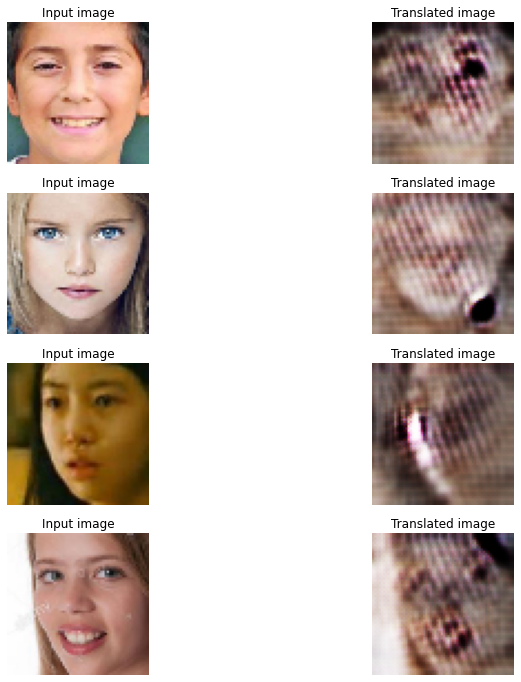

model saved for epoch 0
371/371 [==============================] - 208s 336ms/step - G_loss: 4.9484 - F_loss: 4.4103 - D_X_loss: 0.1331 - D_Y_loss: 0.1285
Epoch 2/10
371/371 [==============================] - ETA: 0s - G_loss: 4.5378 - F_loss: 3.8249 - D_X_loss: 0.1549 - D_Y_loss: 0.1431

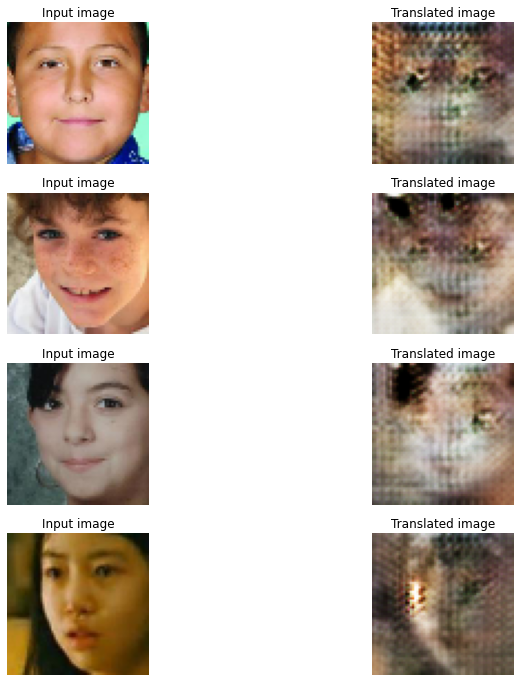

model saved for epoch 1
371/371 [==============================] - 125s 337ms/step - G_loss: 4.5361 - F_loss: 3.8254 - D_X_loss: 0.1549 - D_Y_loss: 0.1435
Epoch 3/10
371/371 [==============================] - ETA: 0s - G_loss: 4.2309 - F_loss: 3.4414 - D_X_loss: 0.1776 - D_Y_loss: 0.1594

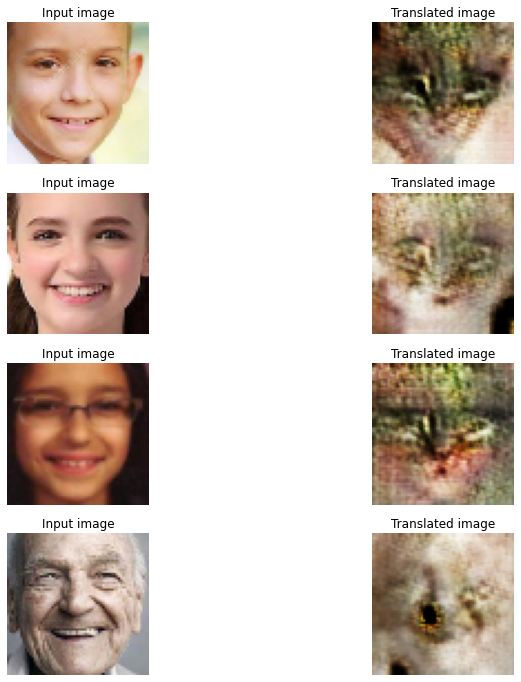

model saved for epoch 2
371/371 [==============================] - 125s 336ms/step - G_loss: 4.2300 - F_loss: 3.4409 - D_X_loss: 0.1776 - D_Y_loss: 0.1595
Epoch 4/10
371/371 [==============================] - ETA: 0s - G_loss: 4.0629 - F_loss: 3.2063 - D_X_loss: 0.1768 - D_Y_loss: 0.1618

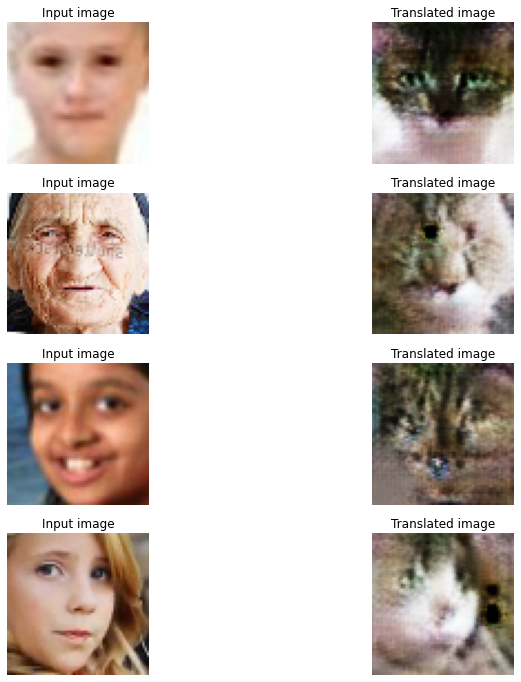

model saved for epoch 3
371/371 [==============================] - 126s 340ms/step - G_loss: 4.0612 - F_loss: 3.2063 - D_X_loss: 0.1768 - D_Y_loss: 0.1620
Epoch 5/10
371/371 [==============================] - ETA: 0s - G_loss: 3.8947 - F_loss: 3.0391 - D_X_loss: 0.1804 - D_Y_loss: 0.1632

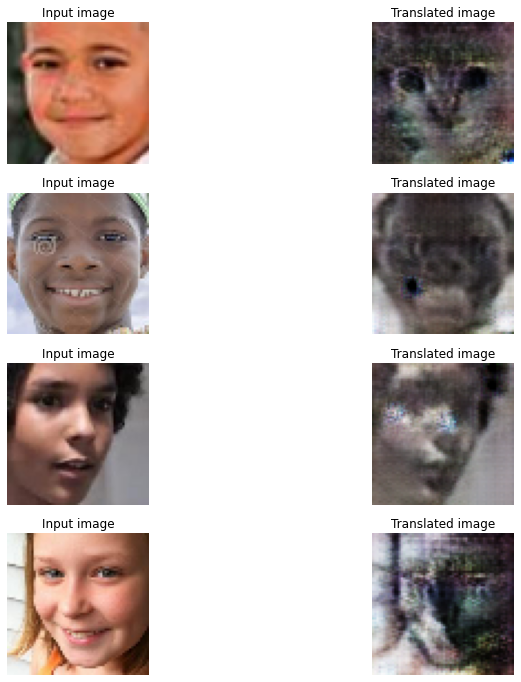

model saved for epoch 4
371/371 [==============================] - 127s 341ms/step - G_loss: 3.8949 - F_loss: 3.0404 - D_X_loss: 0.1805 - D_Y_loss: 0.1632
Epoch 6/10
371/371 [==============================] - ETA: 0s - G_loss: 3.7495 - F_loss: 2.9199 - D_X_loss: 0.1885 - D_Y_loss: 0.1726

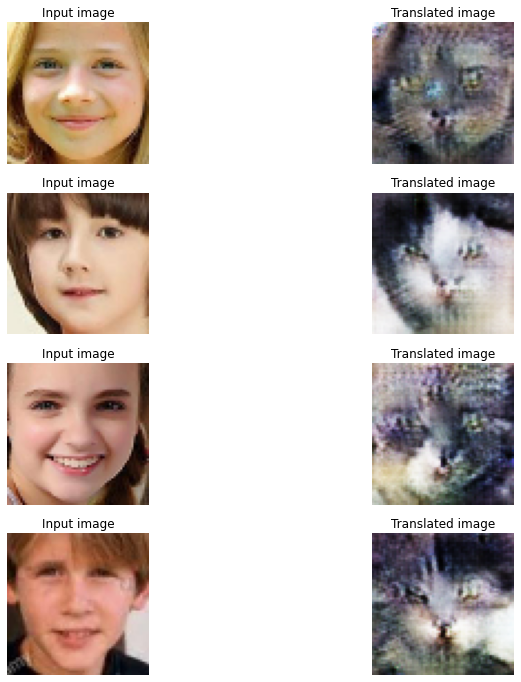

model saved for epoch 5
371/371 [==============================] - 128s 344ms/step - G_loss: 3.7497 - F_loss: 2.9207 - D_X_loss: 0.1885 - D_Y_loss: 0.1726
Epoch 7/10
371/371 [==============================] - ETA: 0s - G_loss: 3.6856 - F_loss: 2.8389 - D_X_loss: 0.1885 - D_Y_loss: 0.1684

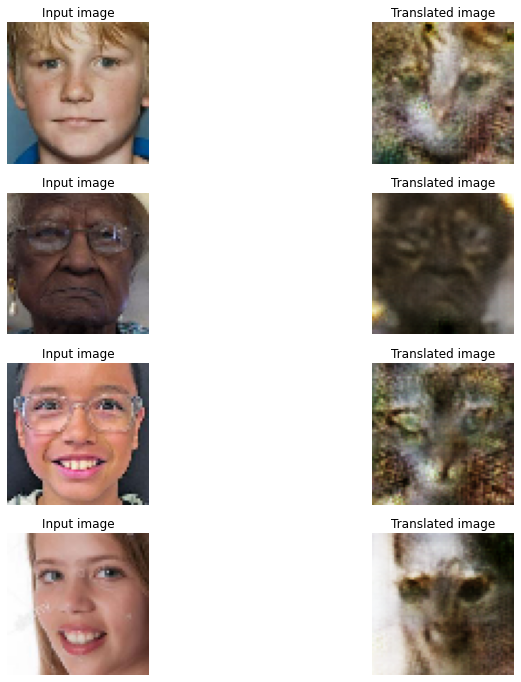

model saved for epoch 6
371/371 [==============================] - 126s 341ms/step - G_loss: 3.6855 - F_loss: 2.8390 - D_X_loss: 0.1885 - D_Y_loss: 0.1686
Epoch 8/10
371/371 [==============================] - ETA: 0s - G_loss: 3.6238 - F_loss: 2.7562 - D_X_loss: 0.1974 - D_Y_loss: 0.1713

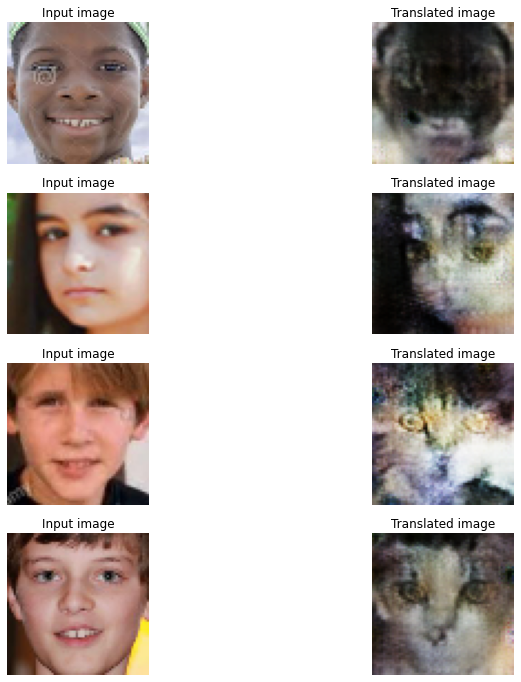

model saved for epoch 7
371/371 [==============================] - 127s 341ms/step - G_loss: 3.6231 - F_loss: 2.7563 - D_X_loss: 0.1973 - D_Y_loss: 0.1712
Epoch 9/10
371/371 [==============================] - ETA: 0s - G_loss: 3.5643 - F_loss: 2.6864 - D_X_loss: 0.1984 - D_Y_loss: 0.1733

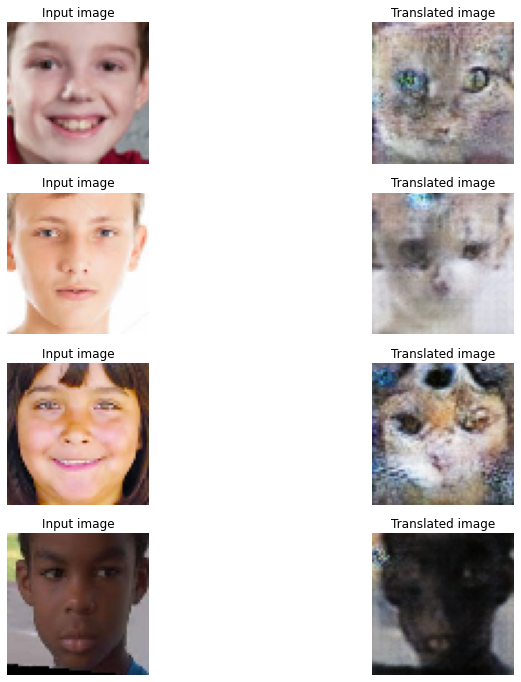

model saved for epoch 8
371/371 [==============================] - 122s 328ms/step - G_loss: 3.5645 - F_loss: 2.6872 - D_X_loss: 0.1983 - D_Y_loss: 0.1732
Epoch 10/10
371/371 [==============================] - ETA: 0s - G_loss: 3.4621 - F_loss: 2.6393 - D_X_loss: 0.2002 - D_Y_loss: 0.1840

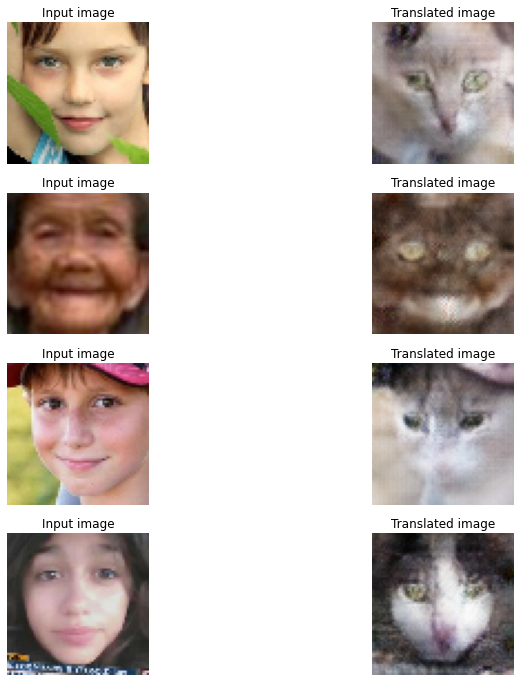

model saved for epoch 9
371/371 [==============================] - 122s 328ms/step - G_loss: 3.4613 - F_loss: 2.6400 - D_X_loss: 0.2001 - D_Y_loss: 0.1841


In [28]:
history=cycle_gan_model.fit(
    tf.data.Dataset.zip((train_human, train_cat_dog)),
    epochs=10,
    callbacks=[plotter,SaveWeightsCallback("/content/gdrive/MyDrive/saved_models/model_{epoch:02d}.h5")],
    #,SaveWeightsCallback("model_weights_{epoch:02d}.h5")
)

In [34]:
# Function used to plot the curves for loss and accuracy:
def plot_curves(history):

  # Plotting the loss curve:
  plt.subplot(211)
  plt.title('ClassX_loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  # Plotting the training loss (blue):
  plt.plot(history.history['G_loss'], color='blue', label='G_loss')
  # Plotting the test loss (red):
  plt.plot(history.history['D_X_loss'], color='red', label='D_X_loss')
  # Legend for the plot:
  plt.legend(['G_loss', 'D_X_loss'], loc='upper left')

  # Plotting the accuracy curve:
  plt.subplot(212)
  plt.title('ClassY_loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  # Plotting the training accuracy (blue):
  plt.plot(history.history['F_loss'], color='blue', label='F_loss')
  # Plotting the test accuracy (red):
  plt.plot(history.history['D_Y_loss'], color='red', label='D_Y_loss')
  # Legend for the plot:
  plt.legend(['F_loss', 'D_Y_loss'], loc='upper left')

  plt.subplots_adjust(top=3)
  plt.show()

print('Done!')

Done!


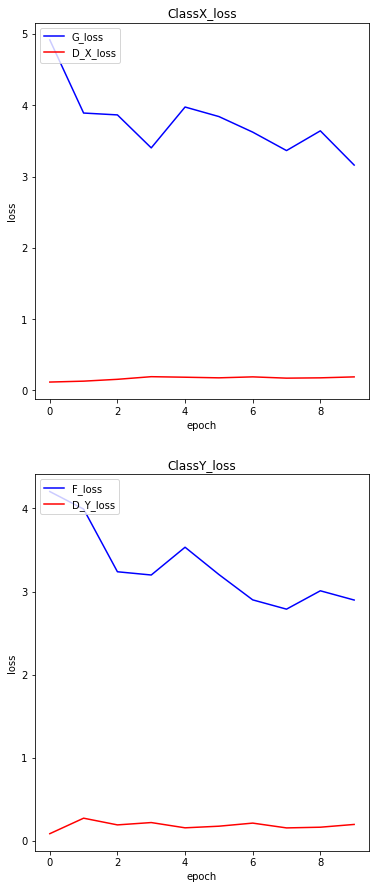

In [35]:
plot_curves(history)

#Testing

##selecting the best model from model checkpoints

Load the model from saved_model directory and select the model that gives the best result.  
Here, the model trained after epoch 3 is selected.

In [75]:
saved_model_path='/content/gdrive/MyDrive/saved_models/210409183_cyclegan_model.h5' 
load_model=keras.models.load_model(saved_model_path,custom_objects={'ReflectionPadding2D': ReflectionPadding2D})
print('model loaded successfully')

model loaded successfully


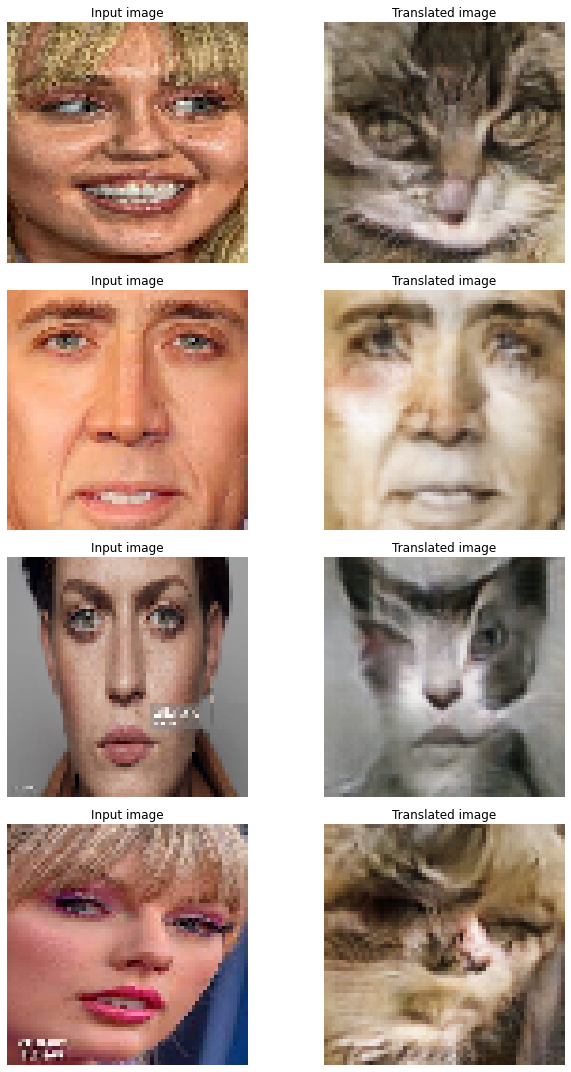

In [79]:
_, ax = plt.subplots(4, 2, figsize=(10, 15))
for i, img in enumerate(test_human.take(4)):
    prediction = load_model(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input image")
    ax[i, 0].set_title("Input image")
    ax[i, 1].set_title("Translated image")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
    prediction = keras.preprocessing.image.array_to_img(prediction)
    prediction.save("/content/gdrive/MyDrive/test_results/predicted_img_{i}.png".format(i=i))
plt.tight_layout()
plt.show()